### The Task

To create a predictive model that can be used to predict the life expectancy in years of any cat. The model will be
created based on the data given in the file (cats.csv). Also to provide the necessary code to productionise the model.

#### Loading the necessary libraries

In [180]:
import warnings

warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,\
     roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline

from sklearn import decomposition

from math import sqrt
from sklearn_pandas import DataFrameMapper

import dill

from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

import statsmodels.api as sm

### Loading the data

In [73]:
cats_df = pd.read_csv('./data/cats.csv')

In [74]:
#Set the index correctly, I will add a column called 'remove' as a flag to identify records to be imputed
cats_df = cats_df.set_index(['Unnamed: 0'])
cats_df.index.name = 'seq'
cats_df['remove'] = False #Used to identify samples to be removed

In [75]:
cats_df.head()

,age at death,breed,date of last vet visit,hair length,height,number of vet visits,weight,remove
seq,,,,,,,,
0,7.0,Siamese,2009-08-02 14:02:18,0.883886,21.611951,5,4.0,False
1,9.0,Siamese,2013-11-27 19:08:52,1.221535,26.451956,10,4.0,False
2,8.0,Manx,2016-01-12 04:39:24,0.967718,18.540191,10,5.0,False
3,8.0,Maine Coon,2000-11-24 18:51:18,1.090641,16.564362,12,7.0,False
4,8.0,Maine Coon,2014-07-03 22:17:26,1.004712,22.535495,7,7.0,False


### Preprocessing

#### Converting datetime columns 

In [76]:
#Identifying wrong datetime format
wrong_date_format = cats_df[cats_df['date of last vet visit'].apply(lambda c: pd.to_datetime(c, errors='coerce')).isnull()]
print(wrong_date_format)
cats_df['date of last vet visit'] = cats_df['date of last vet visit'].apply(lambda c: pd.to_datetime(c, errors='coerce'))
cats_df['remove'].iloc[wrong_date_format.index] = True

del wrong_date_format

     age at death breed date of last vet visit  hair length     height  \
seq                                                                      
47            8.0   Rex    2009-22-12 02:43:43     1.037497  27.393672   

     number of vet visits  weight  remove  
seq                                        
47                      6     6.0   False  


In [6]:
cats_df.describe()

,age at death,hair length,height,number of vet visits,weight
count,299.000000,2.990000e+02,300.000000,300.000000,300.000000
mean,9.006689,3.027706e+09,20.498442,8.296667,3.957667
std,2.892937,5.235392e+10,5.107386,3.820643,2.033624
min,0.000000,6.904537e-01,5.077179,-1.000000,0.000000
25%,7.000000,9.377535e-01,16.958241,6.000000,2.000000
50%,9.000000,1.003253e+00,20.825805,8.000000,4.000000
75%,11.000000,1.067127e+00,24.043067,11.000000,5.250000
max,18.000000,9.052840e+11,33.043014,19.000000,10.000000


In [7]:
cats_df['breed'].value_counts()

Maine Coon    68
Rex           64
Manx          59
Javanese      58
Siamese       50
Donald         1
Name: breed, dtype: int64

### From the data above we can quickly see the following issues
1 - There are two records with missing values in the (age at death) and (hair length variables).
<br>
2 - The variable (vet visits) has negative values, no enough information about why this value. 
<br>
3 - Cats with 0.0 weight and 0 years age.
<br>
4 - Hair length 9.05^11.
<br>
5 - Only one record for Donal cat.
<br>
6 - Zero weight cats.


#### Identifying records with missing values

In [77]:
nan_samples = cats_df[cats_df.isnull().any(axis=1)]
cats_df['remove'].iloc[nan_samples.index] = True
del nan_samples

#### Identifying records with negative values for the number of visit variable

In [78]:
negative_visits = cats_df[cats_df['number of vet visits'] < 0]['number of vet visits']
cats_df['remove'].iloc[negative_visits.index] = True 
del negative_visits

#### Identifying records with 0 age at death

In [79]:
zero_age = cats_df[cats_df['age at death'] <= 0]['age at death']
cats_df['remove'].iloc[zero_age.index] = True
del zero_age

#### Detecting outliers for the length of hair variable
The function below, will identify records that have values that are larger than 1.5 the IQR.

In [80]:
#The function will return the index of the outliers
def detect_outliers(df, col, th):
    q1  = df[col].quantile(.25)
    q2  = df[col].quantile(.75)
    iqr = q1 + q2
    mask = df[col].between(q1-th*iqr, q2+th*iqr, inclusive=True)
    return df.loc[~mask,col].index

In [81]:
outlier_indices = detect_outliers(cats_df, 'hair length', 1.5)
cats_df['remove'].iloc[outlier_indices] = True

#### Identify the breed of 'Donald'

In [82]:
donald_breed = cats_df[cats_df['breed'] == 'Donald']
cats_df['remove'].iloc[donald_breed.index] = True
del donald_breed

#### Identify records with zero weight

In [83]:
zero_weight = cats_df[cats_df['weight'] == 0]['weight']
cats_df['remove'].iloc[zero_weight.index] = True
del zero_weight

#### The below records which have the above issues will be excluded from the analysis.

In [84]:
cats_df[cats_df['remove']==True]

,age at death,breed,date of last vet visit,hair length,height,number of vet visits,weight,remove
seq,,,,,,,,
28,14.0,Donald,2004-02-02 20:27:11,8.880396e-01,9.727390,5,5.0,True
33,6.0,Maine Coon,2007-07-04 02:53:25,8.356103e-01,16.848307,5,0.0,True
47,8.0,Rex,NaT,1.037497e+00,27.393672,6,6.0,True
57,11.0,Manx,2011-11-12 23:23:01,8.684509e-01,21.647929,-1,2.0,True
61,6.0,Maine Coon,2002-02-06 06:49:07,9.420371e-01,23.571271,16,0.0,True
92,7.0,Maine Coon,2007-08-02 16:59:33,9.679410e-01,8.624444,-1,3.0,True
102,17.0,Rex,2007-11-27 07:35:08,1.086447e+00,19.750088,9,0.0,True
108,10.0,Rex,2012-12-10 03:48:52,9.052840e+11,18.661543,9,2.0,True
114,11.0,Siamese,2014-08-14 22:01:44,1.190255e+00,17.747619,6,0.0,True


#### Dropping the column remove

In [85]:
cats_df = cats_df[cats_df['remove']==False]
cats_df = cats_df.drop('remove', axis=1)

### Univariate Analysis
The purpuse of this analysis is to study the distribution of the variables seperately to identify any issue.

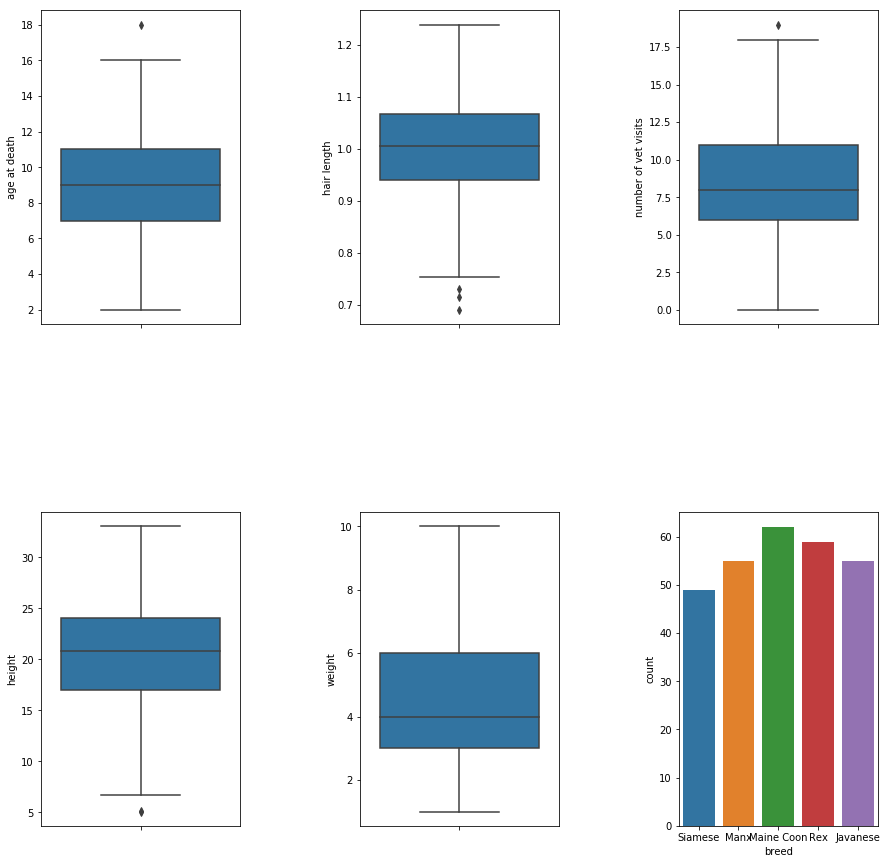

In [26]:
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
fig.subplots_adjust(hspace=0.6, wspace=0.6)
sb.boxplot(cats_df['age at death'], orient='v', ax=axes[0,0])
sb.boxplot(cats_df['hair length'],  orient='v', ax=axes[0,1])
sb.boxplot(cats_df['number of vet visits'], orient='v', ax=axes[0,2])
sb.boxplot(cats_df['height'], orient='v', ax=axes[1,0])
sb.boxplot(cats_df['weight'], orient='v', ax=axes[1,1])
sb.countplot(x=cats_df['breed'],  orient='v', ax=axes[1,2])

### Bivariate Analysis
This analysis is to get a feeling of the relationship between the features and the response varialbe (age at death).

In [28]:
cats_df.describe()

,age at death,hair length,height,number of vet visits,weight
count,280.000000,280.000000,280.000000,280.000000,280.000000
mean,9.032143,1.005091,20.579361,8.450000,4.093929
std,2.767393,0.099954,5.087675,3.706673,1.917304
min,2.000000,0.690454,5.077179,0.000000,1.000000
25%,7.000000,0.939183,16.994714,6.000000,3.000000
50%,9.000000,1.004823,20.865118,8.000000,4.000000
75%,11.000000,1.066356,24.043067,11.000000,6.000000
max,18.000000,1.238662,33.043014,19.000000,10.000000


### Analysing the correlation between the features and the respnse variable

In [88]:
cats_df.head()

,age at death,breed,date of last vet visit,hair length,height,number of vet visits,weight
seq,,,,,,,
0,7.0,Siamese,2009-08-02 14:02:18,0.883886,21.611951,5,4.0
1,9.0,Siamese,2013-11-27 19:08:52,1.221535,26.451956,10,4.0
2,8.0,Manx,2016-01-12 04:39:24,0.967718,18.540191,10,5.0
3,8.0,Maine Coon,2000-11-24 18:51:18,1.090641,16.564362,12,7.0
4,8.0,Maine Coon,2014-07-03 22:17:26,1.004712,22.535495,7,7.0


Correlation between age at death and hair length:
0.03653987062751793


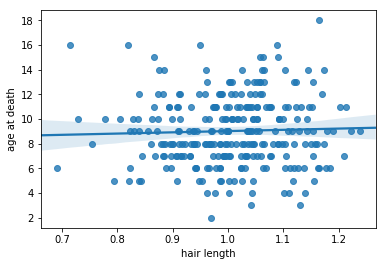

Correlation between age at death and height:
-0.04631251324563596


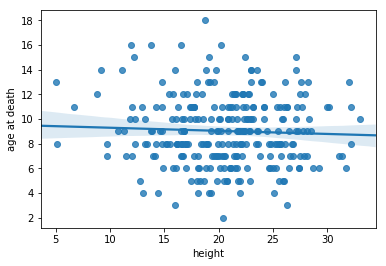

Correlation between age at death and number of vet visits:
-0.03460949093946466


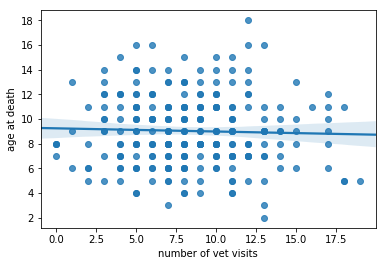

Correlation between age at death and weight:
-0.037994492014238705


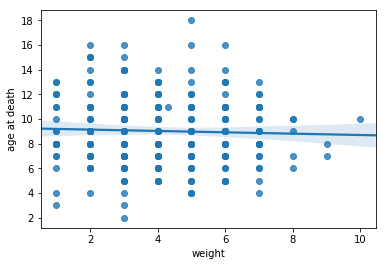

In [89]:
def analyse_correlation(df, dep_variable, indep_variable):
    for v in indep_variable:
         print('Correlation between {} and {}:'.format(dep_variable, v))
         print(np.corrcoef(df[dep_variable].values, df[v].values)[0,1])
         sb.regplot(x=v, y=dep_variable, data=df)
         plt.show()
        
analyse_correlation(cats_df.dropna(), 'age at death', ['hair length', 'height', 'number of vet visits', 'weight'])

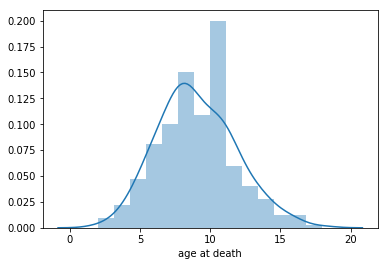

In [90]:
sb.distplot(cats_df['age at death'].dropna())
plt.show()

## Predicting Cat Life Expectancy Using Regression 

We can use two approaches to predict the cat life expectancy. One approach is to consider the problems as 
a classification one, where the response variable (age at death) is splitted into categories, for example low, medium and high and then we create a classification model.  

Because the response varialbe (age at death) is continous, I will use regression for prediction.
Ridge algorithm will be used. Ridge is a linear regression model with norm two penalty on the weights.
Ridge algorithm has few parameters to be tuned. The most important one is (alpha) the penality factor. To find the best parameters, a grid search will be performed.  

In [93]:
X_ = cats_df[cats_df.columns.difference(['age at death','remove'])]
y_ = cats_df['age at death']

In [94]:
X_.head()

,breed,date of last vet visit,hair length,height,number of vet visits,weight
seq,,,,,,
0,Siamese,2009-08-02 14:02:18,0.883886,21.611951,5,4.0
1,Siamese,2013-11-27 19:08:52,1.221535,26.451956,10,4.0
2,Manx,2016-01-12 04:39:24,0.967718,18.540191,10,5.0
3,Maine Coon,2000-11-24 18:51:18,1.090641,16.564362,12,7.0
4,Maine Coon,2014-07-03 22:17:26,1.004712,22.535495,7,7.0


Using sklearn Pipeline, I will create a processing pipeline that takes as input the training data and produces the model. The pipeline consists of the following steps:

#### Feature preprocessing
In this step, the date feature will be splitted into (year, month, day of week, hour) and the categorial features are converted into binary representation using one hot encoding.

#### Tunning the paramters of the Ridge Algorithm.
Using GridSearchCV module, the three parameters (alpha, fit_intercept, normalize) will be searched to find the best combination. GridSearhCV splits the training data using crossover validation. Then, it exhaustively searches all the possible combinations of the parameters to maximise(minimise) a performance metric. 
The performance metric I will use here is the root mean sequare error. 

#### Training the model
Data is splitted into 80% training data and 20% testing.

In [189]:
categaries = cats_df['breed'].unique()
features = cats_df.columns.difference(['age at death'])
label = 'age at death'

X_ = cats_df[features]
y_ = cats_df[label]

X_train, X_test, y_train, y_test = train_test_split(cats_df[features], cats_df[label], test_size=0.2, random_state=0)

def RMSE(y_true, y_pred):
    rmse = sqrt( mean_squared_error(y_true, y_pred) )
    print('RMSE: {}'.format(rmse))
    return rmse

def rmse():
    return make_scorer(RMSE, greater_is_better=False)

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        dt = X.dt
        return pd.concat([dt.year, dt.month, dt.dayofweek, dt.hour], axis=1)


data_mapper = DataFrameMapper([
     ('date of last vet visit', DateEncoder()),
     ('breed', LabelBinarizer())
     ],
     input_df=True, df_out=True, default=None)


ridge_pipeline = Pipeline([
    ('mapper', data_mapper),
    ('classifier', Ridge()) ])

lasso_pipeline = Pipeline([
    ('mapper', data_mapper),
    ('classifier', Lasso()) ])


params_grid = [{'classifier__alpha': np.linspace(0, 1, 10), 'classifier__fit_intercept':[True,False], 'classifier__normalize':[True, False]}]

gs = GridSearchCV(pipeline, params_grid, cv=3, verbose=3, scoring=rmse(),n_jobs=1)

#gs = GridSearchCV(lasso_pipeline, params_grid, cv=3, verbose=3, scoring=rmse(),n_jobs=1)


gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=True 
RMSE: 3.0067794858766423
RMSE: 2.6747362036112228
[CV]  classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=True, score=-3.0067794858766423, total=   0.0s
[CV] classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=True 
RMSE: 2.916228216317089
RMSE: 2.7541657113285725
[CV]  classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=True, score=-2.916228216317089, total=   0.0s
[CV] classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=True 
RMSE: 3.1467071939547764
RMSE: 2.606327737481082
[CV]  classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=True, score=-3.1467071939547764, total=   0.0s
[CV] classifier__alpha=0.0, classifier__fit_intercept=True, classifier__normalize=False 
RMSE: 3.0067794858766406
RMSE: 2.674736203611223

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


RMSE: 2.8135137543580435
[CV]  classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, classifier__normalize=True, score=-2.685736097489479, total=   0.0s
[CV] classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, classifier__normalize=True 
RMSE: 2.8439056593704723
RMSE: 2.7167055211945383
[CV]  classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, classifier__normalize=True, score=-2.8439056593704723, total=   0.0s
[CV] classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, classifier__normalize=False 
RMSE: 2.8999746713379717
RMSE: 2.700756042587507
[CV]  classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, classifier__normalize=False, score=-2.8999746713379717, total=   0.0s
[CV] classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, classifier__normalize=False 
RMSE: 2.825681184253135
RMSE: 2.7826383223930184
[CV]  classifier__alpha=0.1111111111111111, classifier__fit_intercept=True, class

RMSE: 2.648236999440825
[CV]  classifier__alpha=0.3333333333333333, classifier__fit_intercept=False, classifier__normalize=True, score=-2.9835017169392577, total=   0.0s
[CV] classifier__alpha=0.3333333333333333, classifier__fit_intercept=False, classifier__normalize=False 
RMSE: 2.8764834647228517
RMSE: 2.7137522358245034
[CV]  classifier__alpha=0.3333333333333333, classifier__fit_intercept=False, classifier__normalize=False, score=-2.8764834647228517, total=   0.0s
[CV] classifier__alpha=0.3333333333333333, classifier__fit_intercept=False, classifier__normalize=False 
RMSE: 2.764272691885785
RMSE: 2.78921654007591
[CV]  classifier__alpha=0.3333333333333333, classifier__fit_intercept=False, classifier__normalize=False, score=-2.764272691885785, total=   0.0s
[CV] classifier__alpha=0.3333333333333333, classifier__fit_intercept=False, classifier__normalize=False 
RMSE: 2.9835017169392577
RMSE: 2.648236999440825
[CV]  classifier__alpha=0.3333333333333333, classifier__fit_intercept=False,

RMSE: 2.9488431008616685
RMSE: 2.6538143915162804
[CV]  classifier__alpha=0.6666666666666666, classifier__fit_intercept=True, classifier__normalize=False, score=-2.9488431008616685, total=   0.0s
[CV] classifier__alpha=0.6666666666666666, classifier__fit_intercept=False, classifier__normalize=True 
RMSE: 2.8563213225509854
RMSE: 2.7240280049018066
[CV]  classifier__alpha=0.6666666666666666, classifier__fit_intercept=False, classifier__normalize=True, score=-2.8563213225509854, total=   0.0s
[CV] classifier__alpha=0.6666666666666666, classifier__fit_intercept=False, classifier__normalize=True 
RMSE: 2.7401993985943736
RMSE: 2.792499349819575
[CV]  classifier__alpha=0.6666666666666666, classifier__fit_intercept=False, classifier__normalize=True, score=-2.7401993985943736, total=   0.0s
[CV] classifier__alpha=0.6666666666666666, classifier__fit_intercept=False, classifier__normalize=True 
RMSE: 2.9368697456111517
RMSE: 2.660144127603582
[CV]  classifier__alpha=0.6666666666666666, classifi

RMSE: 2.72469996703571
[CV]  classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=True, score=-2.8545330761657315, total=   0.0s
[CV] classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=True 
RMSE: 2.685736097489479
RMSE: 2.8135137543580435
[CV]  classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=True, score=-2.685736097489479, total=   0.0s
[CV] classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=True 
RMSE: 2.8439056593704723
RMSE: 2.7167055211945383
[CV]  classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=True, score=-2.8439056593704723, total=   0.0s
[CV] classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=False 
RMSE: 2.8545330761657315
RMSE: 2.72469996703571
[CV]  classifier__alpha=1.0, classifier__fit_intercept=True, classifier__normalize=False, score=-2.8545330761657315, total=   0.0s
[CV] classifier__alpha=1.0, classifier__fit_i

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=None, df_out=True,
        features=[('date of last vet visit', <__main__.DateEncoder object at 0x1112b1240>), ('breed', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))],
        input_df=True, sparse=False...=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classifier__alpha': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ]), 'classifier__fit_intercept': [True, False], 'classifier__normalize': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(RMSE, greater_is_better=False), verbose=3)

In [190]:
print("Best RMSE score...")
print(-1*gs.best_score_)
print()
print("Best parameters set found on X_train")
print()
print(gs.best_params_)
print()
print('Coefficients of the best model:')
print(gs.best_estimator_.named_steps['classifier'].coef_)
print()
print('Intercept of the best model:')
print(gs.best_estimator_.named_steps['classifier'].intercept_)
print()

#Calculating R^2
y_pred = gs.predict(X_train)
print('Sequared R for the best model:')
print(r2_score(y_pred, y_train))

#Calculating the RMSE
print("Root Mean Square Error:")
print(sqrt( mean_squared_error(y_pred, y_train)))

Best RMSE score...
2.7945053875783734

Best parameters set found on X_train

{'classifier__alpha': 0.1111111111111111, 'classifier__fit_intercept': True, 'classifier__normalize': True}

Coefficients of the best model:
[ 0.  0.  0. -0.  0. -0.  0.  0. -0.  0. -0. -0. -0.]

Intercept of the best model:
9.084821428571429

Sequared R for the best model:
0.0
Root Mean Square Error:
2.7592283413195102


## The residual plot

It is important to validate the model to make sure the assumptions of the linear regression are not violated. This is done using the residual plot.

In [167]:
errors = y_pred - y_train

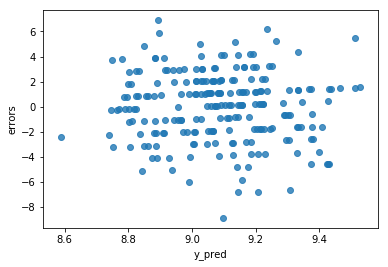

In [168]:
sb.regplot(y_pred, errors, fit_reg=False)
plt.xlabel('y_pred')
plt.ylabel('errors')

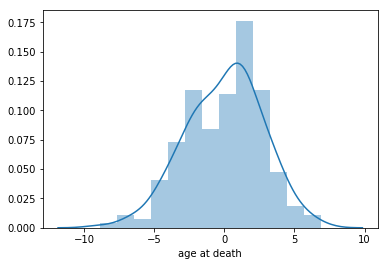

In [169]:
sb.distplot(errors)

## Testing the model on Unseen Data

In [170]:
y_test_pred = model.predict(X_test)
print('Root Mean Sequare Error on the Test Data:')
print(np.sqrt(mean_squared_error(y_test_pred, y_test)))

Root Mean Sequare Error on the Test Data:
2.746423185583662


## Productionize the Model


In [173]:
import dill

with open('./server/model.pk', 'wb') as f:
    dill.dump(clf, f)

## Discussing the results

One major issue of the model generated is the very low value of R^2 which is -222. 
This value indicates that the Ridge linear model is not fitting the data well. I would think the reason is 
due to the features, the features have weak relationship with the response variable. In fact, I have tried few other 
models including polynomial regression and no better results obtained. Therefore, we need to get better features.